The following script was made written by Jens Bager Christensen (jbc53@cam.ac.uk) to perform trajectory analysis using Cell2Fate in relation to the publication Christensen et al., 2025. For further information see [the vignette ](https://cell2fate.readthedocs.io/en/latest/) or see the related [publication](https://www.biorxiv.org/content/10.1101/2023.08.03.551650v1.full.pdf).

In [1]:
#loading the packages required for cell2fate
import cell2fate as c2f
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

/mnt/home3/bayin/jbc53/anaconda3/envs/cell2fate_env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Global seed set to 0


In [2]:
# Data name, where to download data and where to save results
data_path = '/mnt/beegfs6/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/data/'
results_path = '/mnt/beegfs6/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/'

#a name of the data
data_name = 'nonIR_bifurcation_NEPs'

In [4]:
#read in data
adata = sc.read_h5ad(data_path + 'h5ad/nonIR_bifurcation_NEPs.h5ad')

#make clusters a categorical variable
adata.obs["SCT_snn_res.0.6"] = adata.obs["SCT_snn_res.0.6"].astype('category')

#translate the variable (feature) names from Ensembl IDs into gene symbols
#read in the gene symbols
bifurcation_gene_symbols = pd.read_csv(data_path + "bifurcation_features_gene_symbols.txt")
#add them as .var_obs
adata.var_names = bifurcation_gene_symbols["adata@assays$RNA[[]]$gene_name"]


clusters_to_remove = []


adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**5, cluster_column = 'SCT_snn_res.0.6',
                                    remove_clusters = clusters_to_remove,
                                min_shared_counts = 20, n_var_genes= 3000)

Keeping at most 100000 cells per cluster
Filtered out 51382 genes that are detected 20 counts (shared).
Extracted 3000 highly variable genes.


<AxesSubplot:title={'center':'SCT_snn_res.0.6'}, xlabel='UMAP1', ylabel='UMAP2'>

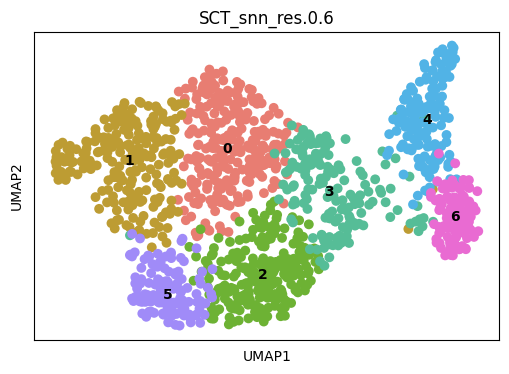

In [5]:
#plot a UMAP with the clusters previously determined using Seurat
fig, ax = plt.subplots(1,1, figsize = (6, 4))

#define the colours used by Seurat for the individual clusters (color HEX found in Illustrator)
plot_col = ["#e87d72", "#bd9c33", "#6db234", "#56bd97", "#51b3e6", "#a08bf8", "#e96bd2"]

sc.pl.umap(adata, color = ['SCT_snn_res.0.6'], s = 200, legend_loc='on data', show = False, ax = ax, palette = plot_col)

In [6]:
#the model is initialised and the maximal number of modules calculated (1.15 times the number of Louvain clusters)
c2f.Cell2fate_DynamicalModel.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced')

n_modules = c2f.utils.get_max_modules(adata)

mod = c2f.Cell2fate_DynamicalModel(adata, n_modules = n_modules)

Leiden clustering ...
         Falling back to preprocessing with `sc.pp.pca` and default params.
Number of Leiden Clusters: 8
Maximal Number of Modules: 9


In [7]:
#the model is trained
mod.train(use_gpu = False)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 500/500: 100%|██████████| 500/500 [22:40<00:00,  2.72s/it, v_num=1, elbo_train=4.88e+6]


In [8]:
#the relevant model parameters are exported from the trained model and save it to the annData object

sample_kwargs = {"num_samples": 20, "batch_size" : 2000,
                         "use_gpu" : False, 'return_samples': True}

adata = mod.export_posterior(adata, sample_kwargs=sample_kwargs)

Sampling global variables, sample: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


<AxesSubplot:title={'center':'Time Uncertainty (sd)'}, xlabel='UMAP1', ylabel='UMAP2'>

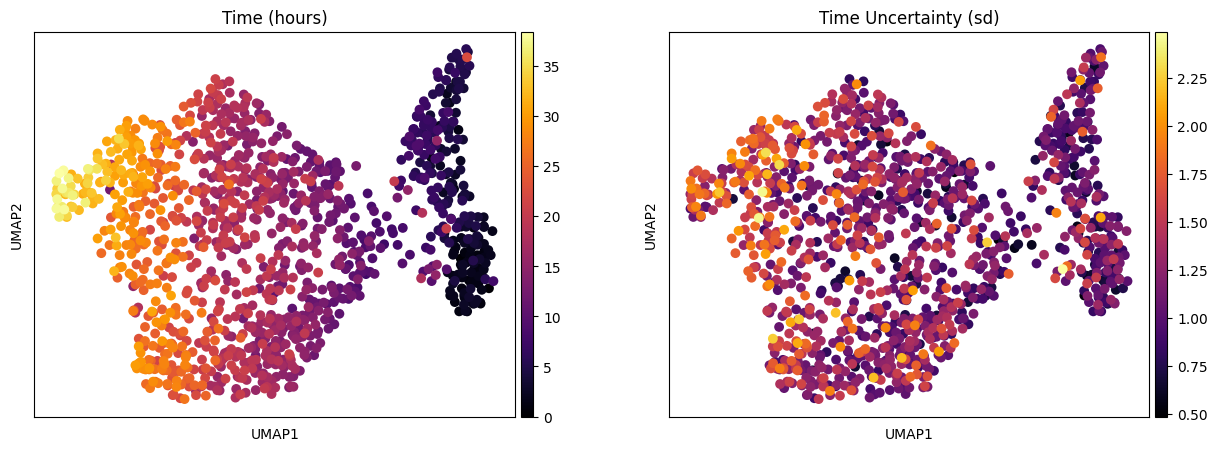

In [9]:
#visualise the computed pseudotime from the analysis

fig, ax = plt.subplots(1,2, figsize = (15, 5))
sc.pl.umap(adata, color = ['Time (hours)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[0])
sc.pl.umap(adata, color = ['Time Uncertainty (sd)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[1])

In [10]:
#Summary statistics can be computed based on the model to visualise the activity of each model among different cell populations

adata = mod.compute_module_summary_statistics(adata)

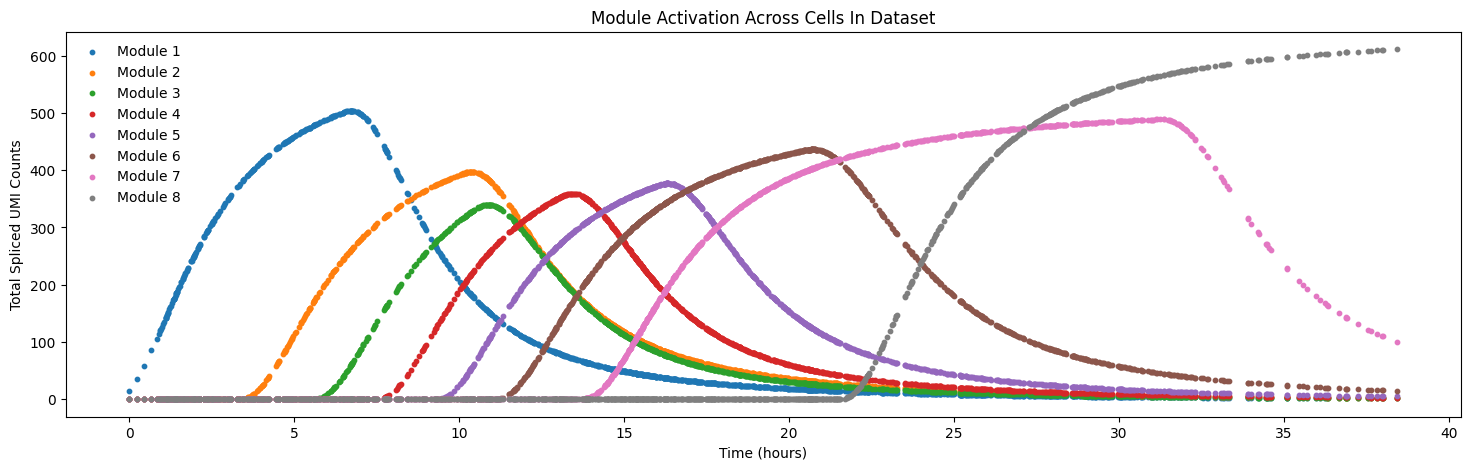

In [11]:
#alternatively, the activity of the modules can be visualised as a scatterplot 

mod.compare_module_activation(adata, chosen_modules = [1,2,3,4,5,6,7,8],
                         save = results_path + data_name + 'neural_module_activation_comparison.pdf')

Computing total RNAvelocity ...


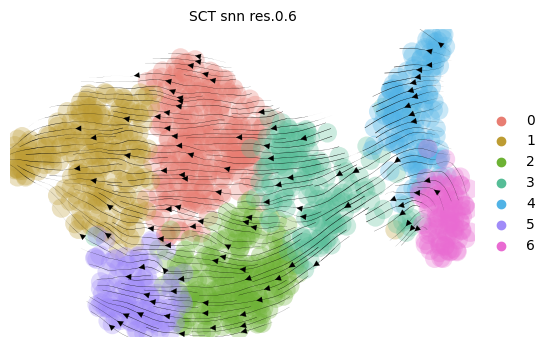

In [17]:
plotting_kwargs={"color": 'SCT_snn_res.0.6', 'legend_fontsize': 10, 'legend_loc': 'right_margin', 'dpi': 300, 'linewidth' : 0.25}

#the cellular trajectories can be computed with the Cell2Fate method, which takes into account the posterior uncertainty when computing the velocity graph and overlaid them on the UMAP.
mod.compute_and_plot_total_velocity(adata, delete = False, plotting_kwargs=plotting_kwargs)


In [ ]:
#a ranked list of features contributing to the different modules can be exported
tab, all_results = mod.get_module_top_features(adata, p_adj_cutoff=0.01, background = adata.var_names)